In [1]:
# !pip install spacy
# !python -m spacy download en_core_web_sm

### Discarding Irrelevant Topics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import sys
import bs4
import nltk.corpus  
from nltk.text import Text
import spacy
from pandarallel import pandarallel
import multiprocessing
import warnings
warnings.filterwarnings('ignore')
import ipywidgets as widgets
widgets.IntSlider()

pd.set_option('max_colwidth', 200)

2023-05-21 23:16:08.632571: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-21 23:16:13.706214: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-21 23:16:13.707580: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

In [2]:
from IPython.display import clear_output
import nltk
nltk.download('popular', halt_on_error=False)
nltk.download('all', halt_on_error=False)
clear_output(wait=False)

In [3]:
workers = multiprocessing.cpu_count() -2

pandarallel.initialize(nb_workers =workers, progress_bar = True, use_memory_fs=False)

INFO: Pandarallel will run on 62 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


### Read the cleaned data

In [4]:
%%time
df = pd.read_parquet('data_cleaned.parquet', engine = 'pyarrow')

CPU times: user 53.6 s, sys: 12.5 s, total: 1min 6s
Wall time: 55.7 s


In [5]:
df.head(2)

,date,month,year,quarter,day,dayofwk,title,text,title_clean,text_clean,title_tokens,text_tokens
0,2021-03-18,3,2021,2021Q1,18,3,Artificial intelligence improves parking efficiency in Chinese cities - People's Daily Online,\n\nArtificial intelligence improves parking efficiency in Chinese cities - People's Daily Online\n\nHome\nChina Politics\nForeign Affairs\nOpinions\nVideo: We Are China\nBusiness\nMilitary\nWorld...,Artificial intelligence improves parking efficiency Chinese cities People Daily Online,Artificial intelligence improves parking efficiency Chinese cities People Daily Online Home China Politics Foreign Affairs Opinions Video We Are China Business Military World Society Culture Trave...,"[Artificial, intelligence, improves, parking, efficiency, Chinese, cities, People, Daily, Online]","[Artificial, intelligence, improves, parking, efficiency, Chinese, cities, People, Daily, Online, Home, China, Politics, Foreign, Affairs, Opinions, Video, We, Are, China, Business, Military, Worl..."
1,2020-02-27,2,2020,2020Q1,27,3,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament,"\nChildren With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament\n \n\nSkip to content\n\t\t\tThursday, February 27, 2020\t\t\n\nLatest:\n\n\n...",Children With Autism Saw Their Learning Social Skills Boosted After Playing With This AI Robot News Parliament,"Children With Autism Saw Their Learning Social Skills Boosted After Playing With This AI Robot News Parliament Skip content Thursday, February 27, 2020 Latest Mansplaining conferences How get fore...","[Children, With, Autism, Saw, Their, Learning, Social, Skills, Boosted, After, Playing, With, This, AI, Robot, News, Parliament]","[Children, With, Autism, Saw, Their, Learning, Social, Skills, Boosted, After, Playing, With, This, AI, Robot, News, Parliament, Skip, content, Thursday, ,, February, 27, ,, 2020, Latest, Mansplai..."


In [6]:
df.shape

(200332, 12)

### Drop the duplicate texts and identify the outliers if any

In [7]:
title_dups = df[df['title'].duplicated() == True].shape[0]
text_dups = df[df['text'].duplicated() == True].shape[0]

print(f"Duplicates in the title column are {title_dups} and the duplicates in the text column are {text_dups}")

Duplicates in the title column are 60109 and the duplicates in the text column are 1768


In [8]:
##The title can be same, considering these are new articles. However, the text being same is something that can be discarded 
df = df.drop_duplicates(subset = 'text')
df.shape

(198564, 12)

In [9]:
%%time
##Get the lengths of the cleaned title and text tokens and discard outliers if any
df['title_len'] = df['title_tokens'].parallel_apply(lambda x: len(x))
df['text_len'] = df['text_tokens'].parallel_apply(lambda x: len(x))

CPU times: user 25.4 s, sys: 10.5 s, total: 35.9 s
Wall time: 37.3 s


In [10]:
## Find the outliers by checking the length of title and text columns and identifying the quartiles which are likely to be the outliers
percentiles = list(range(0, 101, 5))

percentile_values_title = np.percentile(df['title_len'], percentiles)
percentile_values_text = np.percentile(df['text_len'],percentiles)

percentile_table = pd.DataFrame({'Percentile': percentiles, 'title_len': percentile_values_title, 'text_len':percentile_values_text})

percentile_table

,Percentile,title_len,text_len
0,0,1.0,3.0
1,5,7.0,355.0
2,10,7.0,465.0
3,15,8.0,521.0
4,20,9.0,572.0
5,25,9.0,620.0
6,30,10.0,665.0
7,35,10.0,707.0
8,40,10.0,752.0
9,45,11.0,802.0


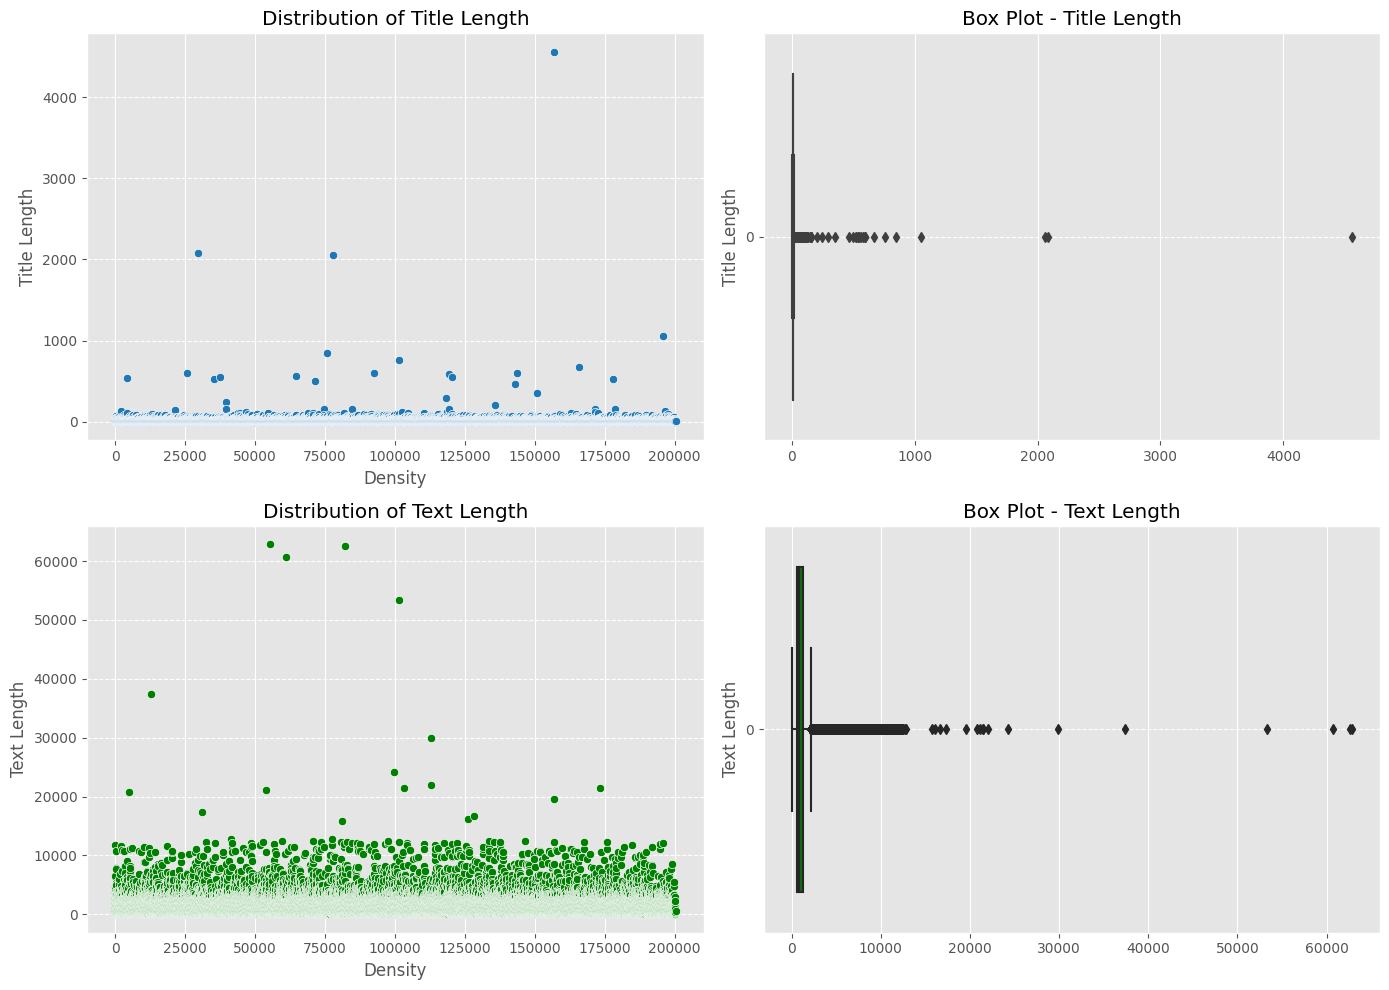

CPU times: user 4.87 s, sys: 4.29 s, total: 9.16 s
Wall time: 1.68 s


In [11]:
%%time
##Plotting the lengths to have a better look at the outlier presence:
plt.style.use('ggplot')
sns.set_palette('Set2')

fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(14, 10))

#Title Length
sns.scatterplot(data=df['title_len'], marker='o', color='tab:blue', ax=ax1[0])
ax1[0].set_xlabel('Density')
ax1[0].set_ylabel('Title Length')
ax1[0].set_title('Distribution of Title Length')
ax1[0].grid(axis='y', linestyle='--')

sns.boxplot(data=df['title_len'], color='tab:blue', orient='h', ax=ax1[1])
ax1[1].set_ylabel('Title Length')
ax1[1].set_title('Box Plot - Title Length')
ax1[1].grid(axis='y', linestyle='--')

#Text Length
sns.scatterplot(data=df['text_len'], marker='o', color='green', ax=ax2[0])
ax2[0].set_xlabel('Density')
ax2[0].set_ylabel('Text Length')
ax2[0].set_title('Distribution of Text Length')
ax2[0].grid(axis='y', linestyle='--')

sns.boxplot(data=df['text_len'], color='green', orient='h', ax=ax2[1])
ax2[1].set_ylabel('Text Length')
ax2[1].set_title('Box Plot - Text Length')
ax2[1].grid(axis='y', linestyle='--')

plt.tight_layout()

plt.show()

In [12]:
##The quartiles look logical and the plots proved the same. Titles above 25 or 30 words, and the text above ~2000 words seems illogical for news articles to have.
##These will be eliminated as a step in discarding irrelevant articles
df_filtered = df.query('(title_len > 5) & (title_len < 30) & (text_len > 100) & (text_len < 2500)')
df_filtered.shape

(181958, 14)

In [13]:
%%time
## Applying custom keyword based stopword removal to further clean the text as a final cleanig step
nlp = spacy.load("en_core_web_sm")
stop_words = nlp.Defaults.stop_words

custom_stopwords = ['free', 'offer', 'sale', 'discount', 'coupon', 'like', 'share', 'comment', 'follow', 'subscribe', 
                    'keyword', 'ranking', 'traffic', 'optimization', 'content', 'disruption', 'transformative', 'leverage', 'synergize',
                    'think outside the box', 'circle back', 'touch base', 'accounting', 'banking', 'bonds', 'brokerage', 'capital',
                    'commodities', 'cost', 'credit', 'customer', 'debt', 'equity', 'exchange', 'loan', 'market', 'money', 'price', 'risk', 
                    'security', 'stock', 'tax', 'trade', 'valuation', 'wealth']

stop_words.update(custom_stopwords)

CPU times: user 616 ms, sys: 39.2 ms, total: 655 ms
Wall time: 712 ms


In [14]:
%%time
pandarallel.initialize(nb_workers = workers, progress_bar=False, use_memory_fs=False)
df_filtered['title_clean'] = df_filtered['title_clean'].parallel_apply(lambda x: " ".join([word.text for word in nlp(x) if word.text not in stop_words]))

INFO: Pandarallel will run on 62 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 746 ms, sys: 5.98 s, total: 6.73 s
Wall time: 43.7 s


In [15]:
%%time
df_filtered['text_clean'] = df_filtered['text_clean'].parallel_apply(lambda x: " ".join([word.text for word in nlp(x) if word.text not in stop_words]))

CPU times: user 4.51 s, sys: 10.8 s, total: 15.3 s
Wall time: 12min 29s


In [16]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181958 entries, 0 to 200331
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          181958 non-null  datetime64[ns]
 1   month         181958 non-null  int64         
 2   year          181958 non-null  int64         
 3   quarter       181958 non-null  period[Q-DEC] 
 4   day           181958 non-null  int64         
 5   dayofwk       181958 non-null  int64         
 6   title         181958 non-null  object        
 7   text          181958 non-null  object        
 8   title_clean   181958 non-null  object        
 9   text_clean    181958 non-null  object        
 10  title_tokens  181958 non-null  object        
 11  text_tokens   181958 non-null  object        
 12  title_len     181958 non-null  int64         
 13  text_len      181958 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(6), period[Q-DEC](1)
memory u

In [17]:
# Save the results
# df_filtered.to_csv("data_to_sentiment.csv", escapechar=",",index=False)

In [18]:
%%time
df_filtered.to_parquet('data_to_sentiment.parquet')

CPU times: user 37.4 s, sys: 6.84 s, total: 44.2 s
Wall time: 49.4 s


In [19]:
import datetime
import time
import pytz
datetime.datetime.now(pytz.timezone('US/Central')).strftime("%a, %d %B %Y %H:%M:%S")

'Sun, 21 May 2023 18:32:09'